In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Fitting the spectrum
from scipy.optimize import curve_fit

#Using csv tables
import pandas as pd

The goal of this notebook is to fit the radio emission of the supernova 1993J, data can be extracted from https://iopscience.iop.org/article/10.1086/523258/pdf and is also aviable in this Github. 

# 1. Introduction.

First, we need to save all the spectrum data in python variables.

In [7]:
#Initialice the data ararys where the first value will be the wavelenght name
data=[]

data_1=[]
data_2=[]
data_3=[]
data_6=[]
data_20=[]

#Extract the data
data= pd.read_csv("Data/Datos SuperNova - 1.2_cm.csv")
data_1.extend(('1.2 cm', data))

data= pd.read_csv("Data/Datos SuperNova - 2_cm.csv")
data_2.extend(('2 cm', data))

data= pd.read_csv("Data/Datos SuperNova - 3.6_cm.csv")
data_3.extend(('3.6 cm', data))

data= pd.read_csv("Data/Datos SuperNova - 6_cm.csv")
data_6.extend(('6 cm', data))

data= pd.read_csv("Data/Datos SuperNova - 20_cm.csv")
data_20.extend(('20 cm', data))

data= []
data.extend((data_1, data_2, data_3, data_6, data_20))

#visualice the data, Flux is in mJy
data[0][1]

,Days,Telescope,Flux,Error
0,11.37,VLA B,18.940,1.905
1,12.33,VLA B,22.487,2.261
2,13.04,VLA B,25.753,2.576
3,13.46,VLA B,25.550,2.578
4,14.25,VLA B,28.640,2.875
...,...,...,...,...
77,3213.38,VLA D/A,2.495,0.282
78,3708.93,VLA A,1.928,0.237
79,3959.47,VLA B/C,1.792,0.191
80,4184.57,VLA A,0.967,0.217


Making a plot to visualice the data.

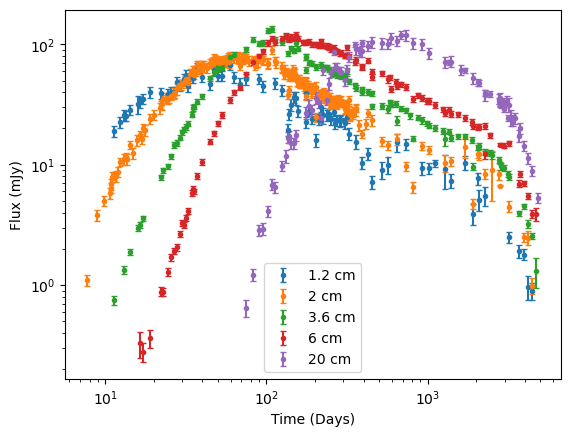

In [5]:
for wavelenght in data:
    plt.errorbar(wavelenght[1].Days, wavelenght[1].Flux, yerr=wavelenght[1].Error, 
                 fmt = '.', capsize=2, label= f'{wavelenght[0]}')
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Flux (mJy)")
plt.xlabel("Time (Days)")
plt.legend()

# 2. Theoretical preview and data.

In order to make this analysis we will be folowing the paper The role of synchrotron self-absorption in the late radio emission from SN 1993J (https://www.aanda.org/articles/aa/abs/2001/30/aah2783/aah2783.html)   (Pérez-Torres, Alberdi and Marcaide). We assume a modified standard interaction model (SIM), where we have a strong interaction between the supernova and the interacting medium; this interactions leads to a self-similarly expanding shell structure, and in this modified scenario the synchrotron emission comes from the shell formed short after the breakout. This emission is assumed to be due relativistic electron population $N(E,r)$ in a magnetic field $B(r)$, and that the injected electron distribution is driven by a power law
$$
            N(E,r)=N_0(r) E^{-p}
$$
We also have some more information from previus observations and asumptions: (i) distance to SN1993J is $D=3.6~Mpc$; (ii) the supernova exploded in March 28, 1993; (iii) supernova deceleration parameter is $m=0.86$; (iv) the width of the radio emiting shell is $\Delta R = 0.3 R_{shock}$; (v) the index of the circumstellar density is $s=1.66$ and (vi) the same temperature proffile as FB98, i.e., 
$$
        T_e(r) =max\left[ T_{15}(10^{15}cm/r), 2 \cdot 10^{5}~K \right],
$$
where $T_{15}$ is the electron temperature in the circumstellar medium at $r= 10^{15}~cm$; in this case it is $1.7\cdot 10^6~K$. The region change occurs for $r_l= 8.5 \cdot 10^{15}~cm$; is important to note that in the first region, the absorption will not be constant, and in the second one it will.

From their VLBI observations we know that 
$$
            B \propto r^{-1} ~~~~~~~~~~~ N_0 \propto r^{-2}.
$$
The fitting parameters will be: 
    (i)   the spectral index of injected electron population, p
    (ii)  Initial magnetic field $B_0$
    (iii) Initial value of the injected function of electrons
    (iv)  Low energy cut for relativistic electrons $\gamma_{min}(r_0) = E_{min}(r_0)/m_ec^2$
The reference radius is $r_0=6.35 \cdot 10^{14}~cm$, corresponding to the outer shell radius at their first data point $t_0=2.34~days$. (MAYBE WE HAVE TO TRANSPORT THIS TO OUR FIRST DATA POINT I STILL DONT KNOW)

From Pacholcyzk expression (3.53) we have that the synchrotron intensity from a power law population of electrons is given by (https://www.mpi-hd.mpg.de/personalhomes/frieger/HEA6.pdf)
$$
    I_\nu = S(\nu) \left(1-e^{-\tau_\nu} \right),
$$
where $S(\nu_1)= \frac{\epsilon_\nu}{\kappa_\nu}$ is the source function and $d\tau_\nu = \kappa_\nu  ds$. This way the flux is simply
$$
    F_\nu = \Omega I_\nu = \frac{\pi R^2}{D^2}I_\nu.
$$
We want model a system where free-free absoption and syncrothron self absortion are present, emission and absorption coefficient for a synchrotron source are
$$
\begin{aligned}
    \mathcal{E}_\nu &=c_5(\gamma) N_0B^{(\gamma+1) / 2}\left(\frac{\nu}{2 c_1}\right)^{(1-\gamma) / 2}, \\
    \kappa_\nu & =c_6(\gamma) N_0B^{(\gamma+2) / 2}\left(\frac{\nu}{2 c_1}\right)^{-(\gamma+4) / 2},
\end{aligned}
$$
and the absorption coefficient for free-free absorption in a relativistic population of electrons is
$$
            \kappa_{f-f} = \frac{N_e^2}{T_e^{1.5} \nu^{2.1}}
$$
Since both absorption coefficients are constant, the intensity is 
$$
            I_\nu = \frac{\epsilon_\nu}{\kappa_{\nu,syn} + \kappa_{\nu,f-f}} (1- e^{-\tau_{\nu,syn}}e^{-\tau_{\nu,f-f}})
$$

Where the constants $c_i$
$$
c_1=\frac{3 e}{4 \pi m^3 c^5}
$$

$$
c_5=\frac{\sqrt{3}}{16 \pi} \frac{e^3}{m c^2}\left(\frac{\gamma+7 / 3}{\gamma+1}\right) \Gamma\left(\frac{3 \gamma-1}{12}\right) \Gamma\left(\frac{3 \gamma+7}{12}\right)
$$

$$
c_6=\frac{\sqrt{3} \pi}{72} e m^5 c^{10}\left(\gamma+\frac{10}{3}\right) \Gamma\left(\frac{3 \gamma+2}{12}\right) \Gamma\left(\frac{3 \gamma+10}{12}\right)
$$


In [6]:
#First of all defininf Pacholcyzk's constants
c1=(const.e.esu*3/(4*np.pi*const.m_e**3*c**5)).cgs.value

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    c5=3**0.5/(16*np.pi)*(const.e.esu**3/(const.m_e*const.c**2))*(p+7/3)/(p+1)*scipy.special.gamma((3*p-1)/12)*scipy.special.gamma((3*p+7)/12)
    #return only the value in SI units to make possible a fit
    return c5.cgs.value
    
def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    c6=np.pi*3**0.5/(72)*const.e.esu*const.m_e**5*const.c**10*(p+10/3)*scipy.special.gamma((3*p+2)/12)*scipy.special.gamma((3*p+10)/12)
    return c6.cgs.value

Now let's deffine the functions needed for the intensity.

In [1]:
def SynchrotronEmissionCoeff(p, B, N0, frequency):
    """
    Returns the emission coefficient for a synchrotron emisison of a population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the emission coefficient want to be calculated

    Output
    :EmissionCoeff: Emission coefficient value
    """

    EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
    return EmissionCoeff

def SynchrotronAbsorptionCoeff(p, B, N0, frequency):
    """
    Returns the absorption coefficient for a synchrotron population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
    return AbsorptionCoeff


def FreeFreeAbsorptionCoeff(Te, Ne, frequency):
    """
    Returns the absorption coefficient for a free free process in cgs units

    Parameters
    :Te: Temperature of the electrons
    :Ne: Electron number density
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    AbsorptionCoeff=N**2/(Te**(1.5)*frequency**(2.1))
    return AbsorptionCoeff

    
def SourceFunc(p, B, N0, Ne, Te, frequency):
    """
    returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :N0: Constant of the power law
    :Ne: Thermal electron number density
    :Te: Temperature of the electrons
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """

    S=SynchrotronEmissionCoeff(p, B, N0, frequency)/(SynchrotronAbsorptionCoeff(p, B, N0, frequency)+ 
                                                 FreeFreeAbsorptionCoeff(Te, Ne, frequency))
    return S

def FreeFreeOpticalDepth(Te, Ne, size, frequency):
    """
    Returns the optical depth for a free free absorption in cgs assuming same external electron temperature as in FB98

    Parameters
    :Te: Temperature of the electrons
    :Ne: Electron number density
    :size: Size of the mitting region
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :tau: Optical depth
    """
    
    tau_vec= FreeFreeAbsorptionCoeff(Te, Ne, frequency)
    return tau

def SynchrotronOpticalDepth(p, B, N0, size, frequency):
    """
    Returns the optical depth for a synchrotron absorption in cgs

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :N0: Constant of the power law
    :size: Size of the mitting region
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :tau: Optical depth
    """

    tau= SynchrotronAbsorptionCoeff(p, B, N0, frequency)*s
    return tau

We can now compute the intensity and the flux.

In [8]:
def SpecInt(p, B, s, N0, size, frequency):
    """
    SpecInt returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :p: exponent of the power law
    :B: Magnetic field
    :N0: Constant of the power law
    :Te: Temperature of the electrons
    :size: Size of the mitting region
    :frequency: frequency at which the specific intensity is computed

    Output
    :I: specific intensity at the given frequency
    """

    #Divide the problem in the 2 regions with different temperature assuming same external electron temperature as in FB98
    Te1=
    Te2=

    size1=
    size2=
    
    S1 =SourceFunc(p, B, N0, Te1, frequency)
    S2 =SourceFunc(p, B, N0, Te2, frequency)
        
    tau1= SynchrotronOpticalDepth(p, B, N0, size1, frequency) + FreeFreeOpticalDepth(Te1, Ne, size1, frequency)
    tau2= SynchrotronOpticalDepth(p, B, N0, size2, frequency) + FreeFreeOpticalDepth(Te2, Ne, size2, frequency)

    I=S1*(1- np.exp(-tau1)) + S2*(1- np.exp(-tau2))
    return I

def solidangle(radius, distance):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :radius: radius of the source
    :distance: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (radius**2)/(distance**2)
    return omega

In [9]:

def FluxatT(time, frequency, p, B0, N0, distance, r0, speed, a, offset=0):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :time: Time at wich the flux is calculated
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B0: Magnetic field when radius is r0
    :N0: Constant of the power law
    :distance: Distance to the source
    :r0: reference radius of the source
    :speed: speed of the expansion
    :a: exponent of the power law describing expansion
    :offset: Optional parameter to make a fit with the offset of the time
    
    Output
    :F: Flux of the source
    """
    #Computing the radius at a given time
    r=PLradius(time- offset, speed, r0, a)
    #Computing number density and magentic field for the corresponding r
    B=Br(r, B0, r0)
    N= Nr(r, N0, r0, p)
    
    F=solidangle(r, distance)*SpecInt(frequency, p, B, r, N)
    return F*1e23 #In order to get from cgs to Jy

We defined our function with frequencies, but sometimes data is given in wavelenght or viceversa, here we make some functions to change between them.

In [10]:
def freqtowavelenght(frequency):
    """
    Transforms from frequency to wavelenght

    Parameters
    :frequency: Input frequency

    Output
    :wavelenght:
    """
    frequency=frequency.to(u.Hz)
    return (const.c/frequency).decompose()

def wavelenghttofreq(wavelenght):
    """
    Transforms from wavelenght to frequency

    Parameters
    :wavelenght: Input wavelenght

    Output
    :frequency:
    """
    wavelenght=wavelenght.to(u.m)
    return (const.c/wavelenght).decompose()

First, let's try to plot this function and see if it behaves well